## IMPORTANT:
Import the zip file with all the desired csv files in there.

In [ ]:
import zipfile
import os

zip_path = "data.zip"  # Change to your actual filename
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped files are in:", extract_path)


In [ ]:
import pandas as pd

In [ ]:
pip install kneed

In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

def load_data(data_dir):
    """Load necessary datasets from the given directory."""
    kyc = pd.read_csv(os.path.join(data_dir, "kyc.csv"))
    kyc_codes = pd.read_csv(os.path.join(data_dir, "kyc_industry_codes.csv"))
    transactions = {
        name: pd.read_csv(os.path.join(data_dir, f"{name}.csv"))
        for name in ["emt", "card", "wire", "cheque", "eft", "abm"]
    }
    return kyc, kyc_codes, transactions

def preprocess_transactions(transactions):
    """
    Standardize date fields, create a received_amount column that captures the absolute
    value of any negative transactions, and adjust card transactions (convert negatives to positives).
    Then merge all transactions into one dataset.
    """
    for key, df in transactions.items():
        df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")
        # Create a new column: if amount is negative, that indicates money received; capture its absolute value.
        df["received_amount"] = df["amount_cad"].apply(lambda x: abs(x) if x < 0 else 0)
        # For card transactions, convert negative amounts to positive for further processing.
        if key == "card":
            df["amount_cad"] = df["amount_cad"].abs()
    return pd.concat(transactions.values(), ignore_index=True)

def compute_transaction_features(all_txns, transactions):
    """Compute transaction-based features for customers."""
    # Compute high value threshold based on overall transactions
    high_value_threshold = all_txns["amount_cad"].quantile(0.95)

    # Aggregate basic statistics per customer, including total amount received from negative transactions.
    txn_summary = all_txns.groupby("customer_id").agg(
        total_transactions=("amount_cad", "count"),
        total_amount_cad=("amount_cad", "sum"),
        avg_transaction_size=("amount_cad", "mean"),
        median_transaction_size=("amount_cad", "median"),
        high_value_txn_count=("amount_cad", lambda x: (x > high_value_threshold).sum()),
        transaction_variance=("amount_cad", "std"),
        total_amount_received=("received_amount", "sum")  # New feature
    )

    # Add per-transaction-type counts
    for name, df in transactions.items():
        txn_summary[f"{name}_count"] = df.groupby("customer_id")["amount_cad"].count()

    # Ensure monetary values are non-negative to avoid issues with log1p
    txn_summary["total_amount_cad"] = txn_summary["total_amount_cad"].clip(lower=0)
    txn_summary["avg_transaction_size"] = txn_summary["avg_transaction_size"].clip(lower=0)

    # Calculate additional monetary features with log transformations
    txn_summary["high_value_ratio"] = txn_summary["high_value_txn_count"] / txn_summary["total_transactions"]
    txn_summary["log_total_amount_cad"] = np.log1p(txn_summary["total_amount_cad"])
    txn_summary["log_avg_transaction_size"] = np.log1p(txn_summary["avg_transaction_size"])

    return txn_summary

def compute_customer_behavior(all_txns, txn_summary):
    """Calculate customer behavior changes over time."""
    latest_txn = all_txns.groupby("customer_id")["transaction_date"].max()
    earliest_txn = all_txns.groupby("customer_id")["transaction_date"].min()
    txn_summary["activity_duration_days"] = (latest_txn - earliest_txn).dt.days

    txn_summary["transactions_per_day"] = txn_summary["total_transactions"] / (txn_summary["activity_duration_days"] + 1)

    inter_txn_diffs = all_txns.sort_values(["customer_id", "transaction_date"]).groupby("customer_id")["transaction_date"].apply(
        lambda x: x.diff().dt.days.dropna()
    )
    inter_txn_mean = inter_txn_diffs.groupby("customer_id").mean()
    inter_txn_std = inter_txn_diffs.groupby("customer_id").std()

    txn_summary["inter_txn_mean_days"] = inter_txn_mean
    txn_summary["inter_txn_std_days"] = inter_txn_std

    return txn_summary

def compute_high_risk_provinces(final_dataset):
    """Determine high-risk provinces dynamically based on transaction behavior."""
    province_txn_stats = final_dataset.groupby("province").agg(
        avg_txn_amount=("total_amount_cad", "mean"),
        high_value_txn_ratio=("high_value_txn_count", "mean"),
        customer_count=("customer_id", "count"),
    )
    risk_threshold = province_txn_stats["avg_txn_amount"].quantile(0.95)
    return province_txn_stats[province_txn_stats["avg_txn_amount"] > risk_threshold].index.tolist()

def add_industry_feature(final_dataset, kyc_codes, kyc):
    """Merge industry code information from kyc_industry_codes into final dataset."""
    kyc["industry_code"] = kyc["industry_code"].astype(str)
    kyc_codes["industry_code"] = kyc_codes["industry_code"].astype(str)

    kyc_with_industry = kyc.merge(kyc_codes, on="industry_code", how="left")

    desc_col = None
    if "industry_description" in kyc_with_industry.columns:
        desc_col = "industry_description"
    elif "description" in kyc_with_industry.columns:
        desc_col = "description"
    elif "industry" in kyc_with_industry.columns:
        desc_col = "industry"
    else:
        print("Warning: No industry description column found in kyc_industry_codes. Skipping industry feature merge.")

    if desc_col:
        final_dataset = final_dataset.merge(kyc_with_industry[["customer_id", desc_col]], on="customer_id", how="left")
        final_dataset = final_dataset.rename(columns={desc_col: "industry_description"})
    else:
        final_dataset["industry_description"] = np.nan

    return final_dataset

def add_business_interaction_features(final_dataset):
    """Add interaction features such as amount per employee."""
    final_dataset["amount_per_employee"] = final_dataset["total_amount_cad"] / final_dataset["employee_count"].replace(0, np.nan)
    final_dataset["amount_per_employee"].fillna(0, inplace=True)
    return final_dataset

def add_unsupervised_features(final_dataset):
    """Add clustering labels and anomaly scores as features."""
    numeric_features = [
        "total_transactions", "total_amount_cad", "avg_transaction_size", "median_transaction_size",
        "high_value_txn_count", "transaction_variance", "transactions_per_day",
        "inter_txn_mean_days", "inter_txn_std_days"
    ]
    data_for_unsupervised = final_dataset[numeric_features].fillna(0)

    kmeans = KMeans(n_clusters=5, random_state=42)
    final_dataset["cluster_label"] = kmeans.fit_predict(data_for_unsupervised)

    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    final_dataset["isolation_forest_score"] = iso_forest.fit_predict(data_for_unsupervised)

    return final_dataset

def add_industry_tier_features(final_dataset, all_txns, kyc, kyc_codes):
    """Categorize industries into tiers and count unique interactions per customer."""
    txns_with_industry = all_txns.merge(kyc[['customer_id', 'industry_code']], on='customer_id', how='left')
    txns_with_industry['industry_code'] = txns_with_industry['industry_code'].astype(str)
    kyc_codes["industry_code"] = kyc_codes["industry_code"].astype(str)

    txns_with_industry = txns_with_industry.merge(kyc_codes, on='industry_code', how='left')

    if 'industry' not in txns_with_industry.columns:
        print("Industry description column not found in merged data; skipping industry tier features.")
        return final_dataset

    industry_totals = txns_with_industry.groupby('industry')['amount_cad'].sum().reset_index()
    industry_totals['tier'] = pd.qcut(industry_totals['amount_cad'], q=3, labels=['small', 'medium', 'large'])
    industry_to_tier = dict(zip(industry_totals['industry'], industry_totals['tier']))
    txns_with_industry['tier'] = txns_with_industry['industry'].map(industry_to_tier)

    customer_tier_counts = txns_with_industry.groupby(['customer_id', 'tier'])['industry'].nunique().unstack(fill_value=0)
    customer_tier_counts = customer_tier_counts.rename(columns={
        'large': 'large_industry',
        'medium': 'medium_industry',
        'small': 'small_industry'
    })

    final_dataset = final_dataset.merge(customer_tier_counts, on='customer_id', how='left')
    final_dataset[['large_industry', 'medium_industry', 'small_industry']] = final_dataset[["large_industry", "medium_industry", "small_industry"]].fillna(0).astype(int)

    return final_dataset

def finalize_dataset(final_dataset, high_risk_provinces):
    """Perform final cleaning and feature engineering."""
    final_dataset["high_risk_province_flag"] = final_dataset["province"].isin(high_risk_provinces).astype(int)
    final_dataset["transaction_variance"].fillna(0, inplace=True)

    final_dataset["has_business"] = ((final_dataset["employee_count"].fillna(0) > 0) | (final_dataset["sales"].fillna(0) > 0)).astype(int)
    final_dataset["employee_count"].fillna(0, inplace=True)
    final_dataset["sales"].fillna(0, inplace=True)
    final_dataset[["province", "city"]] = final_dataset[["province", "city"]].fillna("na")

    txn_columns = ["emt_count", "card_count", "wire_count", "cheque_count", "eft_count", "abm_count"]
    for col in txn_columns:
        if col in final_dataset.columns:
            final_dataset[col].fillna(0, inplace=True)

    if "established_date" in final_dataset.columns:
        final_dataset.drop(columns=["established_date"], inplace=True)

    final_dataset["onboard_date"] = pd.to_datetime(final_dataset["onboard_date"], errors='coerce')
    final_dataset["onboard_date"].fillna(final_dataset["onboard_date"].mean(), inplace=True)

    return final_dataset

def remove_redundant_features(final_dataset):
    """
    Drop redundant features:
      - Raw monetary features in favor of log-transformed ones.
      - Unsupervised outputs if fresh clustering is to be performed.
      - Duplicate industry identifier (keep industry_description).
      - Individual transaction type counts and derived ratio (amount_per_employee).
    """
    redundant_cols = [
        "total_amount_cad", "avg_transaction_size", "cluster_label", "isolation_forest_score",
        "industry_code", "industry_description"
    ]
    final_dataset.drop(columns=redundant_cols, inplace=True)
    return final_dataset

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

def main():
    data_dir = "/content/data"
    kyc, kyc_codes, transactions = load_data(data_dir)

    # Process transactions and compute features
    all_txns = preprocess_transactions(transactions)
    txn_summary = compute_transaction_features(all_txns, transactions)
    txn_summary = compute_customer_behavior(all_txns, txn_summary)

    # Merge and create features
    final_dataset = txn_summary.merge(kyc, on="customer_id", how="left")
    final_dataset = add_industry_feature(final_dataset, kyc_codes, kyc)
    high_risk_provinces = compute_high_risk_provinces(final_dataset)
    final_dataset = finalize_dataset(final_dataset, high_risk_provinces)
    final_dataset = add_business_interaction_features(final_dataset)
    final_dataset = add_unsupervised_features(final_dataset)
    final_dataset = add_industry_tier_features(final_dataset, all_txns, kyc, kyc_codes)
    final_dataset = remove_redundant_features(final_dataset)

    # Store ID columns before preprocessing
    id_cols = ['customer_id', 'onboard_date']
    id_data = final_dataset[id_cols].copy()

    # Fill missing values appropriately
    numeric_cols = final_dataset.select_dtypes(include=['int64', 'float64']).columns
    final_dataset[numeric_cols] = final_dataset[numeric_cols].fillna(final_dataset[numeric_cols].median())
    final_dataset["inter_txn_mean_days"] = final_dataset["inter_txn_mean_days"].fillna(0)
    final_dataset["inter_txn_std_days"] = final_dataset["inter_txn_std_days"].fillna(0)

    # Separate categorical columns
    categorical_cols = ['city', 'province', 'country']

    # Handle categorical features
    print("Encoding categorical features...")
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_array = ohe.fit_transform(final_dataset[categorical_cols])
    encoded_df = pd.DataFrame(
        encoded_array,
        columns=ohe.get_feature_names_out(categorical_cols),
        index=final_dataset.index
    )

    # Prepare numeric features
    print("Preparing numeric features...")
    numeric_features = final_dataset.drop(columns=categorical_cols + id_cols)

    # Scale numeric features
    scaler = StandardScaler()
    scaled_numeric = scaler.fit_transform(numeric_features)
    scaled_numeric_df = pd.DataFrame(
        scaled_numeric,
        columns=numeric_features.columns,
        index=numeric_features.index
    )

    # Combine scaled numeric and encoded categorical features
    print("Combining features...")
    preprocessed_data = pd.concat([scaled_numeric_df, encoded_df], axis=1)

    # Optimize PCA components
    print("Optimizing PCA components...")
    pca_full = PCA(random_state=42)
    pca_full.fit(preprocessed_data)

    # Calculate variance explained
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Find optimal number of components using multiple criteria
    variance_threshold = 0.95
    n_components_95 = np.argmax(cumulative_variance >= variance_threshold) + 1

    # Calculate eigenvalues
    eigenvalues = pca_full.explained_variance_

    # Kaiser criterion (eigenvalues > 1)
    n_components_kaiser = sum(eigenvalues > 1)

    # Scree plot analysis
    from kneed import KneeLocator
    n_components_elbow = KneeLocator(
        range(1, len(eigenvalues) + 1),
        eigenvalues,
        curve='convex',
        direction='decreasing'
    ).knee

    print(f"\nPCA Component Analysis:")
    print(f"Components for 95% variance: {n_components_95}")
    print(f"Components (Kaiser criterion): {n_components_kaiser}")
    print(f"Components (Elbow method): {n_components_elbow}")

    # Choose the optimal number of components
    n_components = max(n_components_elbow, n_components_kaiser)
    print(f"\nSelected optimal components: {n_components}")

    # Apply final PCA
    print("Applying final PCA transformation...")
    pca = PCA(n_components=n_components, random_state=42)
    df_pca = pca.fit_transform(preprocessed_data)

    # Create final dataset
    df_pca = pd.DataFrame(
        df_pca,
        columns=[f"PC_{i+1}" for i in range(n_components)],
        index=preprocessed_data.index
    )

    # Add back ID columns
    final_df = pd.concat([id_data, df_pca], axis=1)

    # Calculate and print variance explained by selected components
    variance_explained = np.sum(explained_variance_ratio[:n_components])
    print(f"\nVariance explained by {n_components} components: {variance_explained:.4f}")

    # Generate component importance summary
    print("\nTop 5 components explanation:")
    for i in range(min(5, n_components)):
        print(f"PC_{i+1}: {explained_variance_ratio[i]:.4f} of variance")

    # Export final dataset
    final_df.to_csv("/content/final_aml_dataset.csv", index=False)
    print("\nDataset successfully created!")

    return final_df, pca, scaler

if __name__ == "__main__":
    final_df, pca, scaler = main()



<ipython-input-5-7b5cb0979fb4>:174: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataset["transaction_variance"].fillna(0, inplace=True)
<ipython-input-5-7b5cb0979fb4>:177: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

Encoding categorical features...
Preparing numeric features...
Combining features...
Optimizing PCA components...

PCA Component Analysis:
Components for 95% variance: 24
Components (Kaiser criterion): 10
Components (Elbow method): 29

Selected optimal components: 29
Applying final PCA transformation...

Variance explained by 29 components: 0.9740

Top 5 components explanation:
PC_1: 0.1631 of variance
PC_2: 0.0960 of variance
PC_3: 0.0664 of variance
PC_4: 0.0572 of variance
PC_5: 0.0511 of variance

Dataset successfully created!


# Creating the Dataset

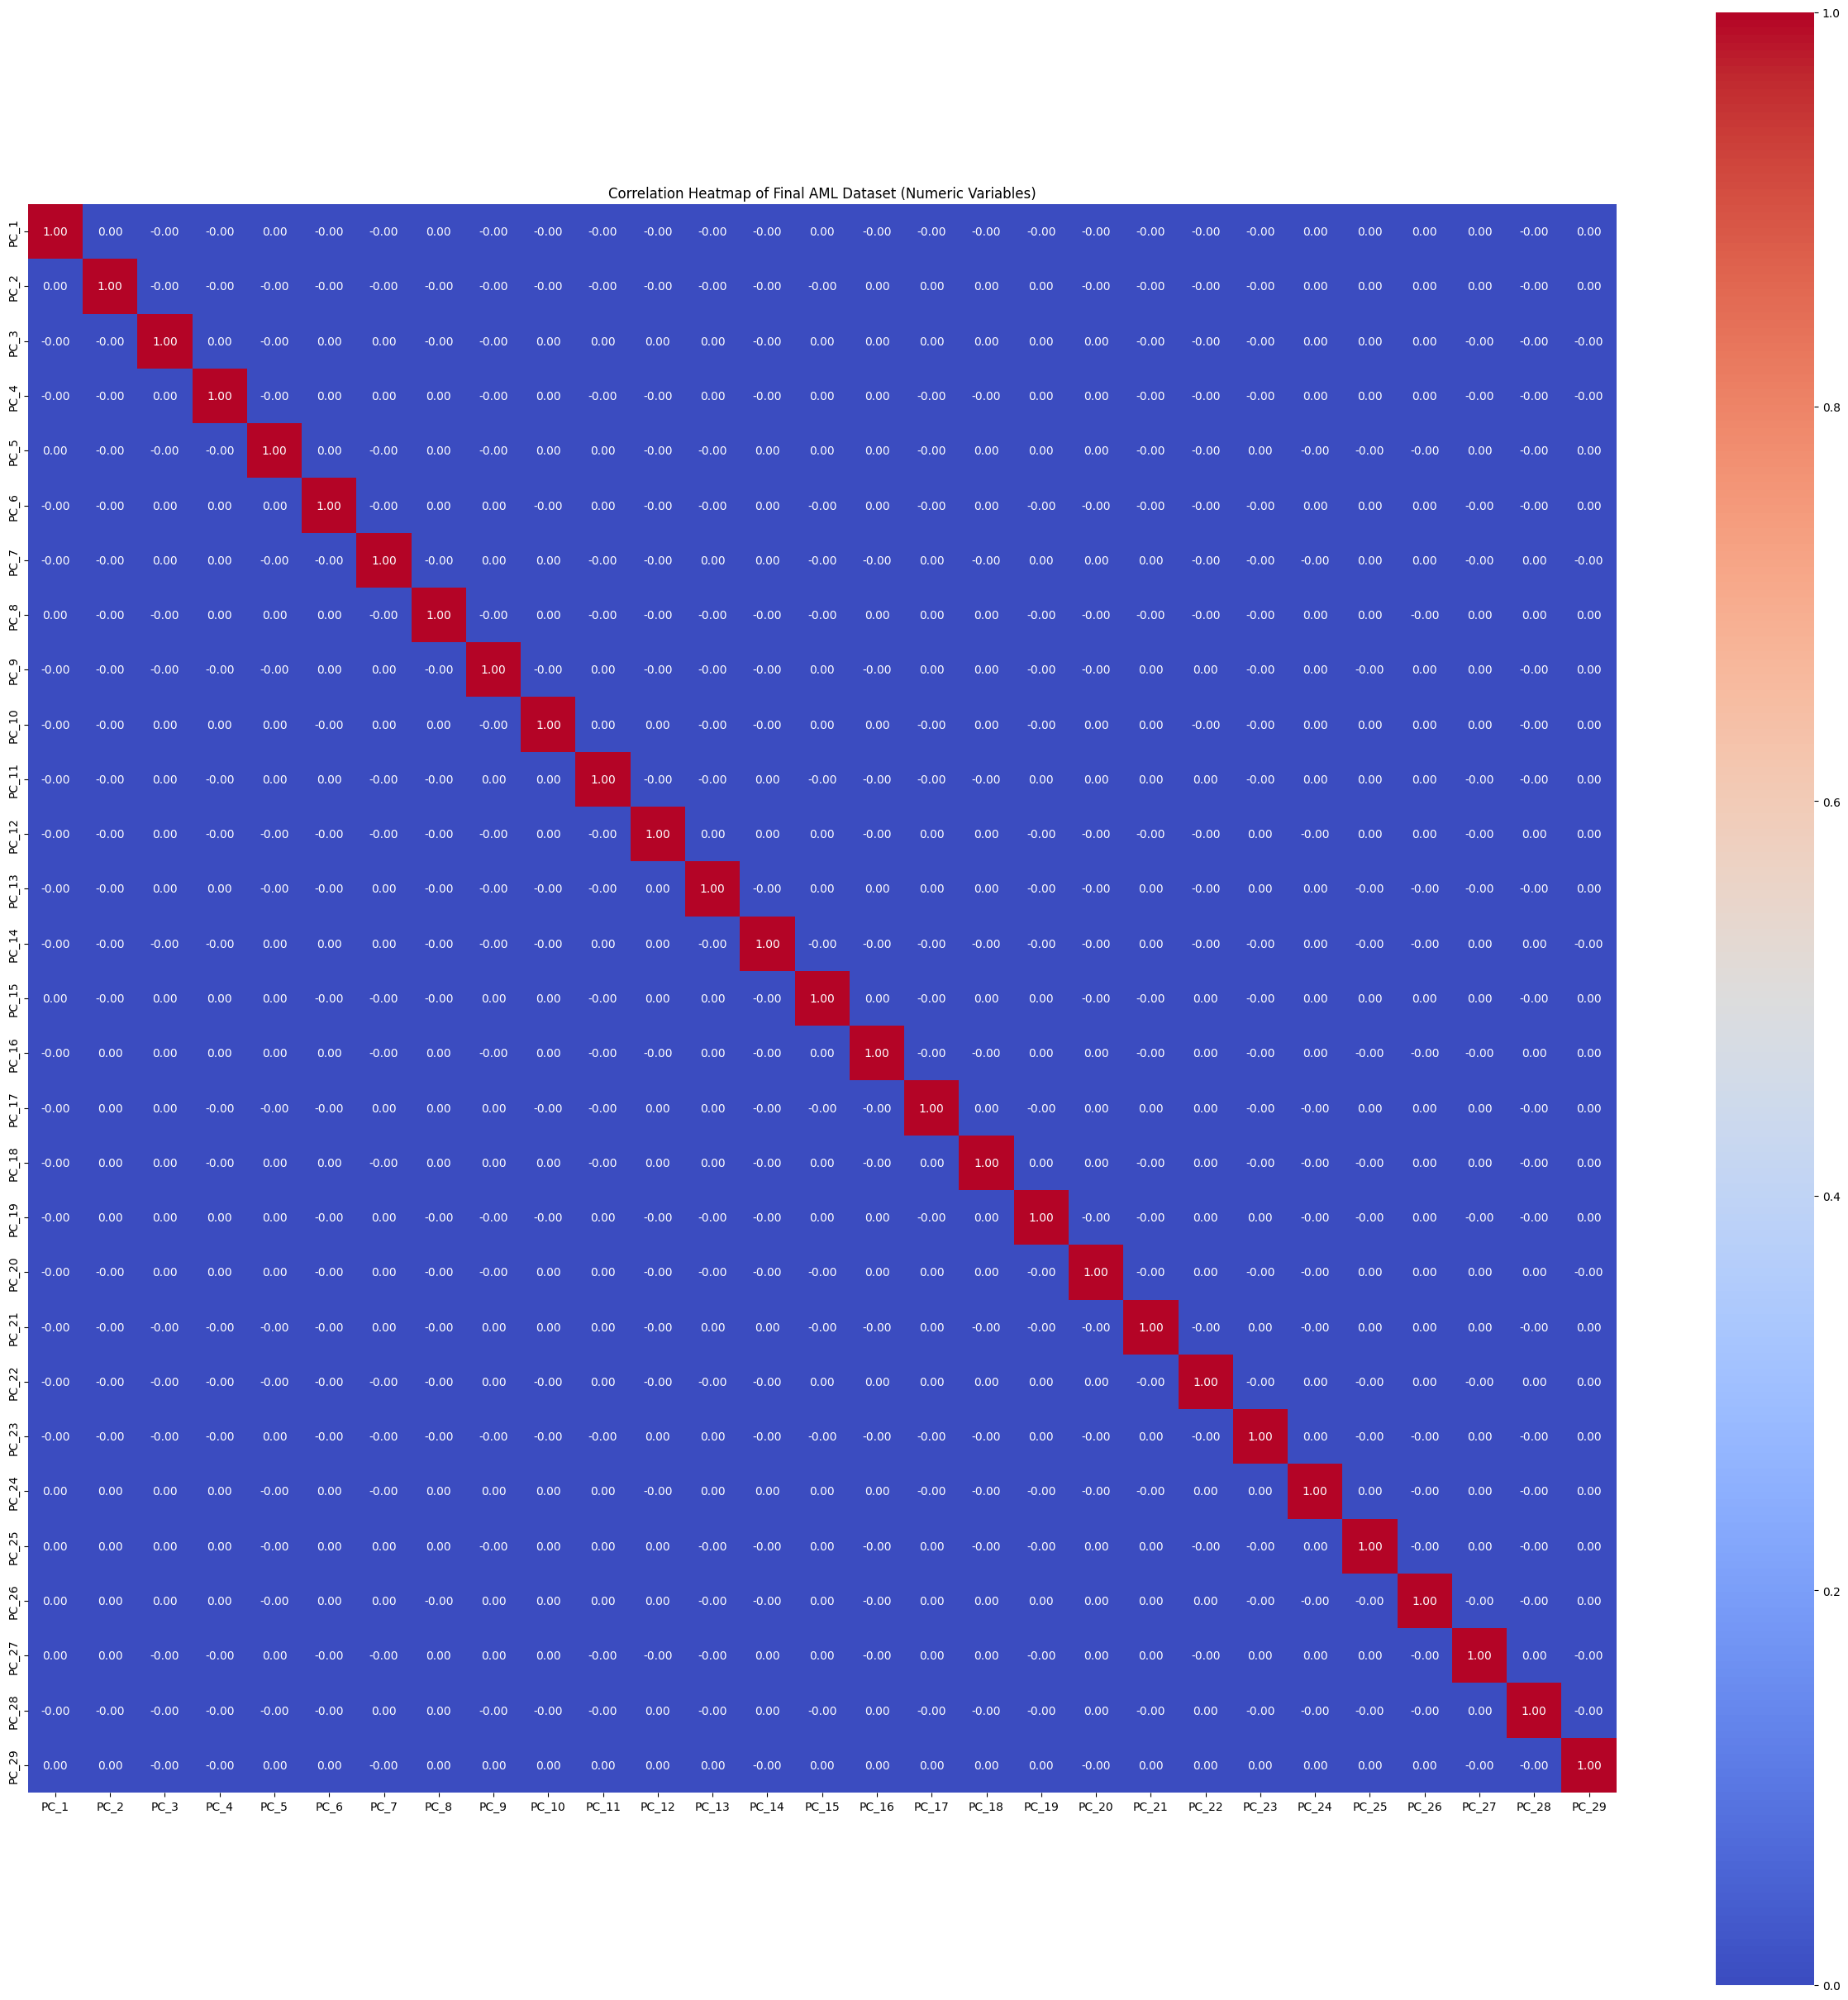

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the final AML dataset
file_path = "/content/final_aml_dataset.csv"
df = pd.read_csv(file_path)

# Select numeric columns (these include variables such as total_transactions, median_transaction_size,
# high_value_txn_count, transaction_variance, total_amount_received, high_value_ratio, log_total_amount_cad,
# log_avg_transaction_size, activity_duration_days, transactions_per_day, inter_txn_mean_days,
# inter_txn_std_days, employee_count, sales, amount_per_employee, large_industry, medium_industry, small_industry)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute the correlation matrix for these numeric variables
corr_matrix = df[numeric_cols].corr()

# Set up the figure: a 31x31 inch grid to display the full heatmap
plt.figure(figsize=(31, 31))

# Create the heatmap
# - annot=True: Display correlation coefficients in each cell
# - fmt=".2f": Format the annotations to 2 decimal places
# - cmap="coolwarm": Use a diverging colormap for positive/negative correlations
# - square=True: Make each cell square-shaped
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)

# Add a title
plt.title("Correlation Heatmap of Final AML Dataset (Numeric Variables)")

# Display the plot
plt.show()


# Different Modelling Techniques:

# Culmination of different techniques

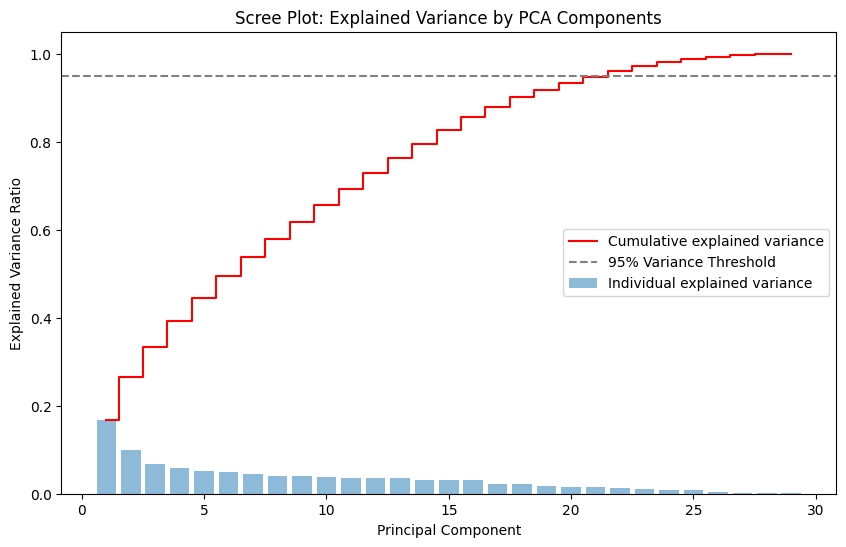

Optimal number of PCA components to retain 95% variance: 22


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the dataset (make sure to use the numeric data you want to analyze)
file_path = "final_aml_dataset.csv"
df = pd.read_csv(file_path)

# For PCA, we work with numerical features. If needed, drop non-numeric columns.
# Here, we'll drop customer_id and onboard_date, and also convert any categorical variables.
df_numeric = df.drop(columns=['customer_id', 'onboard_date'])
# Optionally, convert categorical columns if they are not numeric (here we assume country, province, city are numeric encodings)


# -------------------------------
# 1. Scree Plot: Explained Variance
# -------------------------------
pca_full = PCA(random_state=42)
pca_full.fit(df_numeric )
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
# Bar plot for individual explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5,
        align='center', label='Individual explained variance')
# Step plot for cumulative explained variance
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Cumulative explained variance', color='red')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot: Explained Variance by PCA Components')
plt.axhline(y=0.95, color='gray', linestyle='--', label='95% Variance Threshold')
plt.legend(loc='best')
plt.show()

# Determine optimal number of components to explain 95% of variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of PCA components to retain 95% variance: {n_components}")



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from kneed import KneeLocator

def find_optimal_eps(data, min_samples):
    """Find optimal eps parameter for DBSCAN using k-distance graph"""
    neigh = NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    return distances[knee.knee]

def optimize_kmeans(data, max_clusters=20):
    """Find optimal number of clusters for KMeans using elbow method"""
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_clusters + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Find elbow point
    knee = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
    optimal_k = knee.knee

    return optimal_k

# ------------------------------
# 1. Load the Dataset
# ------------------------------
df = pd.read_csv("final_aml_dataset.csv")

# ------------------------------
# 2. Drop Irrelevant Columns and Handle Missing Values
# ------------------------------
df.drop(columns=['customer_id', 'onboard_date'], inplace=True)
df_pca = df.dropna()  # Handle missing values

# ------------------------------
# 6. Anomaly Detection Using Three Techniques
# ------------------------------
# Technique 1: DBSCAN with optimal parameters
min_samples = int(np.log(len(df_pca)))  # Rule of thumb
optimal_eps = find_optimal_eps(df_pca, min_samples)
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df_pca)
dbscan_anomalies = (dbscan_labels == -1).astype(int)

# Technique 2: Isolation Forest with cross-validation
contamination = 0.1  # Start with estimate, adjust based on domain knowledge
iso_forest = IsolationForest(
    contamination=contamination,
    random_state=42,
    n_estimators=100,  # Increased for better stability
    max_samples='auto'
)
iso_labels = iso_forest.fit_predict(df_pca)
iso_anomalies = (iso_labels == -1).astype(int)

# Technique 3: KMeans with optimal clusters
optimal_k = optimize_kmeans(df_pca)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(df_pca)
distances = np.linalg.norm(df_pca - kmeans.cluster_centers_[kmeans_labels], axis=1)

# Use Interquartile Range (IQR) for threshold
Q1 = np.percentile(distances, 25)
Q3 = np.percentile(distances, 75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR
kmeans_anomalies = (distances > threshold).astype(int)

# ------------------------------
# 7. Combine Anomaly Flags with Weighted Voting
# ------------------------------
# Weight the predictions based on their reliability
weights = {
    'dbscan': 0.4,
    'isolation_forest': 0.3,
    'kmeans': 0.3
}

weighted_scores = (
    weights['dbscan'] * dbscan_anomalies +
    weights['isolation_forest'] * iso_anomalies +
    weights['kmeans'] * kmeans_anomalies
)

# Flag as anomaly if weighted score exceeds threshold
combined_anomaly = (weighted_scores > 0.4).astype(int)
df['Anomaly'] = combined_anomaly

# ------------------------------
# 8. Save Results and Generate Report
# ------------------------------
# Save results
df.to_csv("final_aml_anomalies.csv", index=False)

# Print summary statistics
print("\nAnomaly Detection Summary:")
print("-" * 30)
print(f"Total samples analyzed: {len(df)}")
print(f"Anomalies detected: {combined_anomaly.sum()}")
print(f"Anomaly percentage: {(combined_anomaly.sum() / len(df) * 100):.2f}%")
print("\nDetection by Method:")
print(f"DBSCAN: {dbscan_anomalies.sum()} anomalies")
print(f"Isolation Forest: {iso_anomalies.sum()} anomalies")
print(f"KMeans: {kmeans_anomalies.sum()} anomalies")

# Optional: Generate visualization of results
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.hist(distances, bins=50)
plt.axvline(threshold, color='r', linestyle='--')
plt.title('KMeans Distance Distribution')

plt.subplot(132)
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=combined_anomaly, cmap='viridis')
plt.title('PCA Visualization of Anomalies')

plt.subplot(133)
plt.bar(['Normal', 'Anomaly'],
        [len(df) - combined_anomaly.sum(), combined_anomaly.sum()])
plt.title('Anomaly Distribution')

plt.tight_layout()
plt.savefig('anomaly_detection_results.png')
plt.close()


Anomaly Detection Summary:
------------------------------
Total samples analyzed: 16226
Anomalies detected: 1064
Anomaly percentage: 6.56%

Detection by Method:
DBSCAN: 93 anomalies
Isolation Forest: 1623 anomalies
KMeans: 1245 anomalies



Summary Statistics for PC_1:
           count  mean   std   min   25%   50%   75%    max  skewness  \
Label                                                                   
Anomaly   1064.0  1.99  5.66 -5.60 -1.97  1.43  4.23  54.79      3.02   
Normal   15162.0 -0.14  1.51 -4.85 -1.01 -0.21  0.63   8.31      0.63   

         kurtosis  
Label              
Anomaly     19.93  
Normal       1.74  
Outliers (IQR Method) - Normal: 579, Anomaly: 521

Summary Statistics for PC_2:
           count  mean   std    min   25%   50%   75%    max  skewness  \
Label                                                                    
Anomaly   1064.0  0.96  4.66 -28.97 -1.75  0.41  3.17  50.52      1.28   
Normal   15162.0 -0.07  1.12  -4.06 -0.78 -0.12  0.55  10.73      0.64   

         kurtosis  
Label              
Anomaly     17.48  
Normal       2.75  
Outliers (IQR Method) - Normal: 428, Anomaly: 457

Summary Statistics for PC_3:
           count  mean   std   min   25%   50%   75%    max 

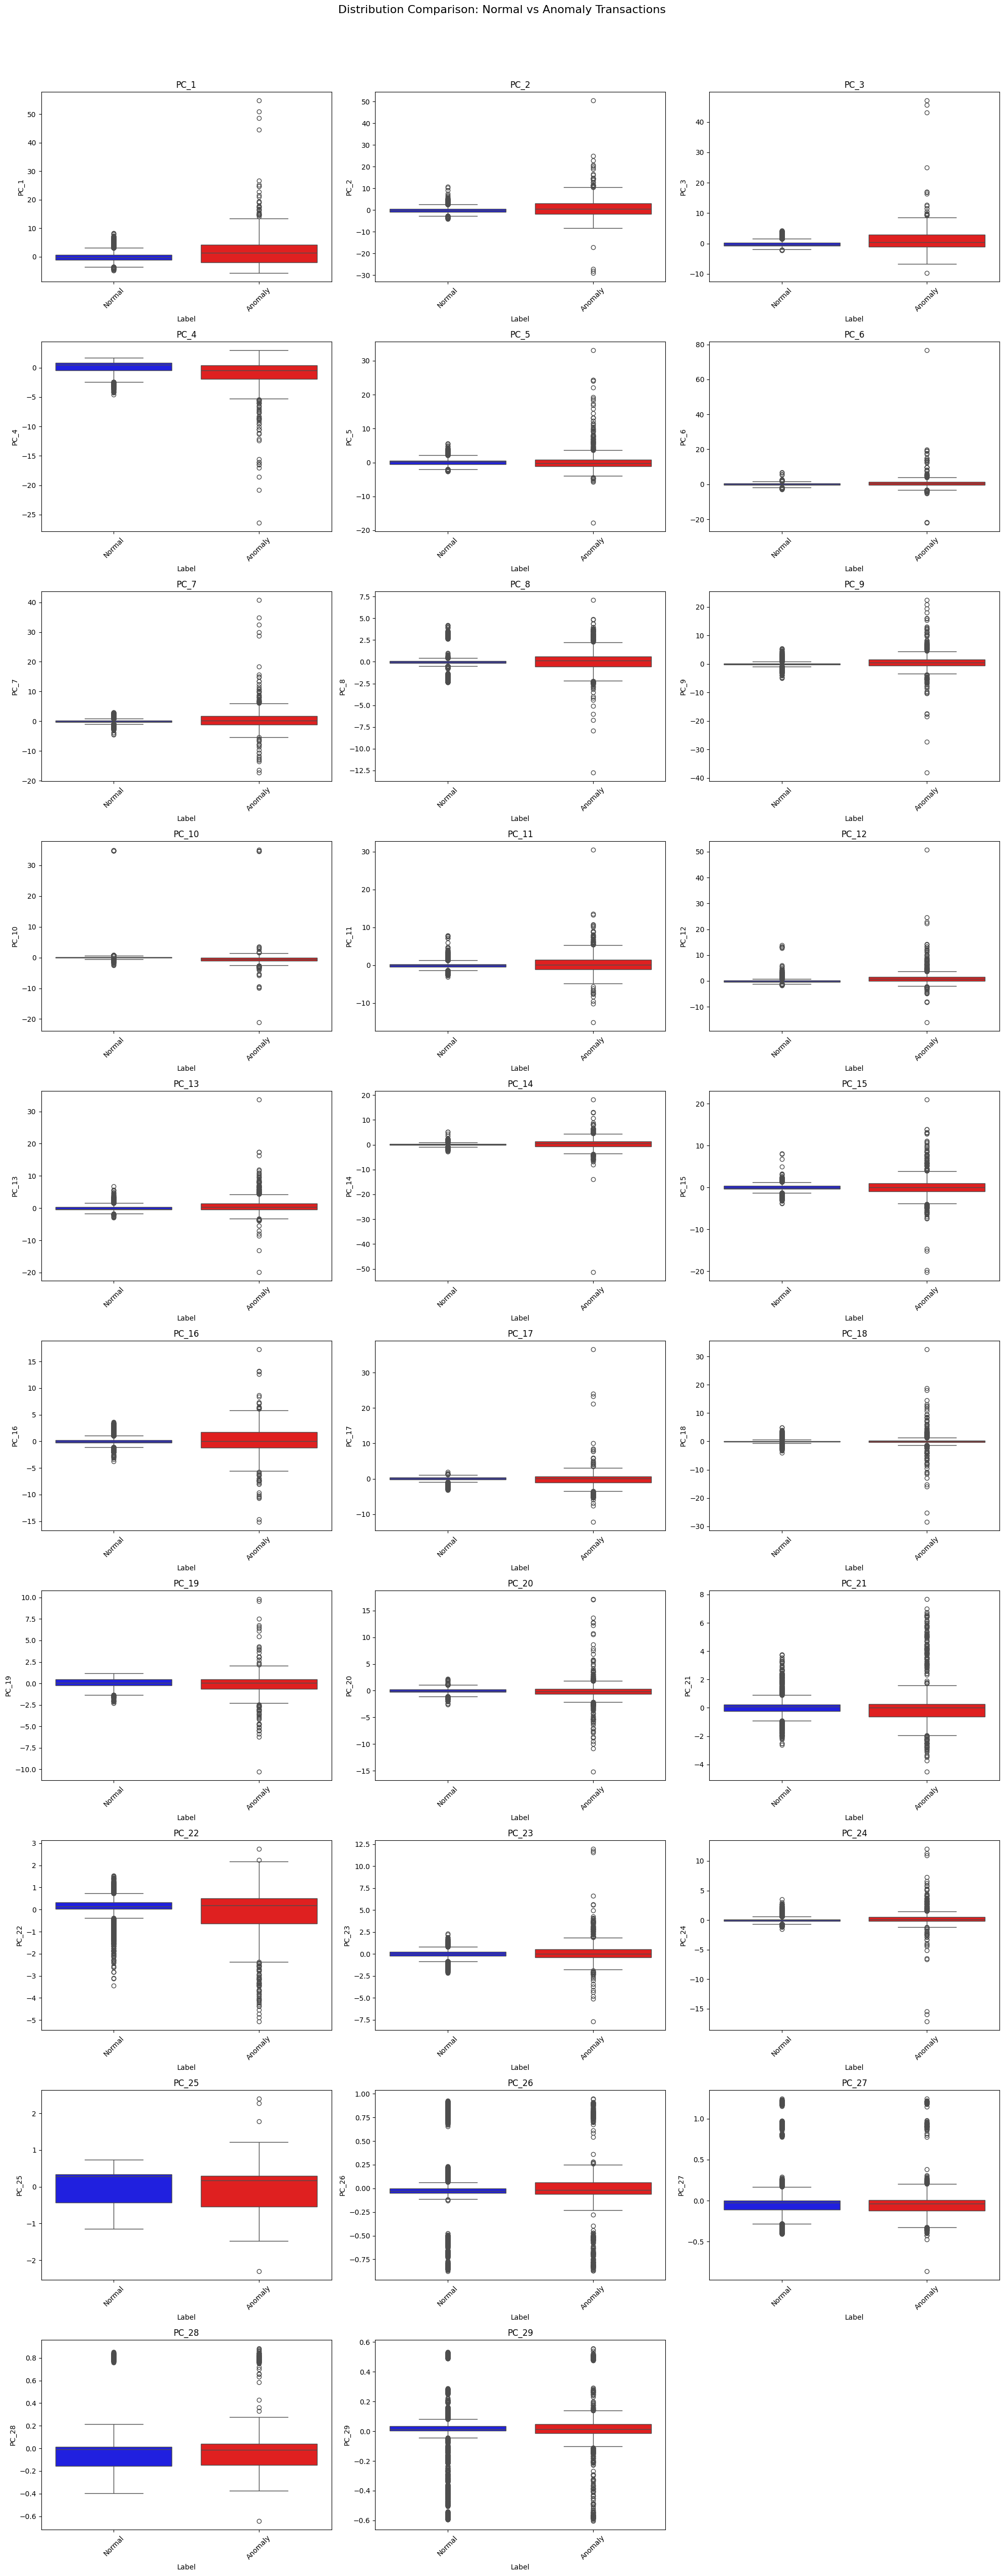


Statistical Tests:
--------------------------------------------------

PC_1:
Mann-Whitney U test p-value: 0.0000
Kolmogorov-Smirnov test p-value: 0.0000
Effect size (Cohen's d): -0.51

PC_2:
Mann-Whitney U test p-value: 0.0000
Kolmogorov-Smirnov test p-value: 0.0000
Effect size (Cohen's d): -0.30

PC_3:
Mann-Whitney U test p-value: 0.0000
Kolmogorov-Smirnov test p-value: 0.0000
Effect size (Cohen's d): -0.45

PC_4:
Mann-Whitney U test p-value: 0.0000
Kolmogorov-Smirnov test p-value: 0.0000
Effect size (Cohen's d): 0.59

PC_5:
Mann-Whitney U test p-value: 0.0000
Kolmogorov-Smirnov test p-value: 0.0000
Effect size (Cohen's d): -0.17

PC_6:
Mann-Whitney U test p-value: 0.0000
Kolmogorov-Smirnov test p-value: 0.0000
Effect size (Cohen's d): -0.21

PC_7:
Mann-Whitney U test p-value: 0.0000
Kolmogorov-Smirnov test p-value: 0.0000
Effect size (Cohen's d): -0.22

PC_8:
Mann-Whitney U test p-value: 0.0000
Kolmogorov-Smirnov test p-value: 0.0000
Effect size (Cohen's d): -0.11

PC_9:
Mann-Whitne

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def create_comprehensive_boxplots(df):
    """
    Generates boxplots for numerical columns, comparing normal vs anomaly transactions.
    Also computes summary statistics, outliers, and statistical tests.
    """

    if 'Anomaly' not in df.columns:
        raise ValueError("The dataset must contain an 'Anomaly' column.")

    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Anomaly' in numerical_columns:
        numerical_columns.remove('Anomaly')

    df['Label'] = df['Anomaly'].map({0: 'Normal', 1: 'Anomaly'})

    n_cols = 3
    n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    fig.suptitle('Distribution Comparison: Normal vs Anomaly Transactions', fontsize=16, y=1.02)
    axes_flat = axes.flatten()

    for idx, column in enumerate(numerical_columns):
        ax = axes_flat[idx]
        sns.boxplot(x='Label', y=column, data=df, hue='Label',
                    palette={'Normal': 'blue', 'Anomaly': 'red'},
                    dodge=False, ax=ax)
        ax.get_legend().remove() if ax.get_legend() else None

        if df[column].max() / (df[column].min() + 1e-10) > 1000:
            ax.set_yscale('log')
            ax.set_title(f'{column} (Log Scale)')
        else:
            ax.set_title(column)

        ax.tick_params(axis='x', rotation=45)

        # Summary statistics
        summary_stats = df.groupby('Label')[column].describe().round(2)
        summary_stats['skewness'] = df.groupby('Label')[column].apply(stats.skew).round(2)
        summary_stats['kurtosis'] = df.groupby('Label')[column].apply(stats.kurtosis).round(2)
        print(f"\nSummary Statistics for {column}:")
        print(summary_stats)

        # Outlier detection using IQR
        normal_data = df[df['Label'] == 'Normal'][column]
        anomaly_data = df[df['Label'] == 'Anomaly'][column]

        Q1, Q3 = normal_data.quantile(0.25), normal_data.quantile(0.75)
        IQR = Q3 - Q1
        normal_outliers = ((normal_data < (Q1 - 1.5 * IQR)) | (normal_data > (Q3 + 1.5 * IQR))).sum()
        anomaly_outliers = ((anomaly_data < (Q1 - 1.5 * IQR)) | (anomaly_data > (Q3 + 1.5 * IQR))).sum()
        print(f"Outliers (IQR Method) - Normal: {normal_outliers}, Anomaly: {anomaly_outliers}")

    for idx in range(len(numerical_columns), len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    plt.show()

    # Statistical Tests
    print("\nStatistical Tests:")
    print("-" * 50)
    for column in numerical_columns:
        normal_data = df[df['Label'] == 'Normal'][column].dropna()
        anomaly_data = df[df['Label'] == 'Anomaly'][column].dropna()

        u_stat, u_p = stats.mannwhitneyu(normal_data, anomaly_data, alternative='two-sided')
        ks_stat, ks_p = stats.ks_2samp(normal_data, anomaly_data)
        cohens_d = (normal_data.mean() - anomaly_data.mean()) / np.sqrt((normal_data.var() + anomaly_data.var()) / 2)

        print(f"\n{column}:")
        print(f"Mann-Whitney U test p-value: {u_p:.4f}")
        print(f"Kolmogorov-Smirnov test p-value: {ks_p:.4f}")
        print(f"Effect size (Cohen's d): {cohens_d:.2f}")

# Example usage
file_path = "/content/final_aml_anomalies.csv"
df = pd.read_csv(file_path)
create_comprehensive_boxplots(df)

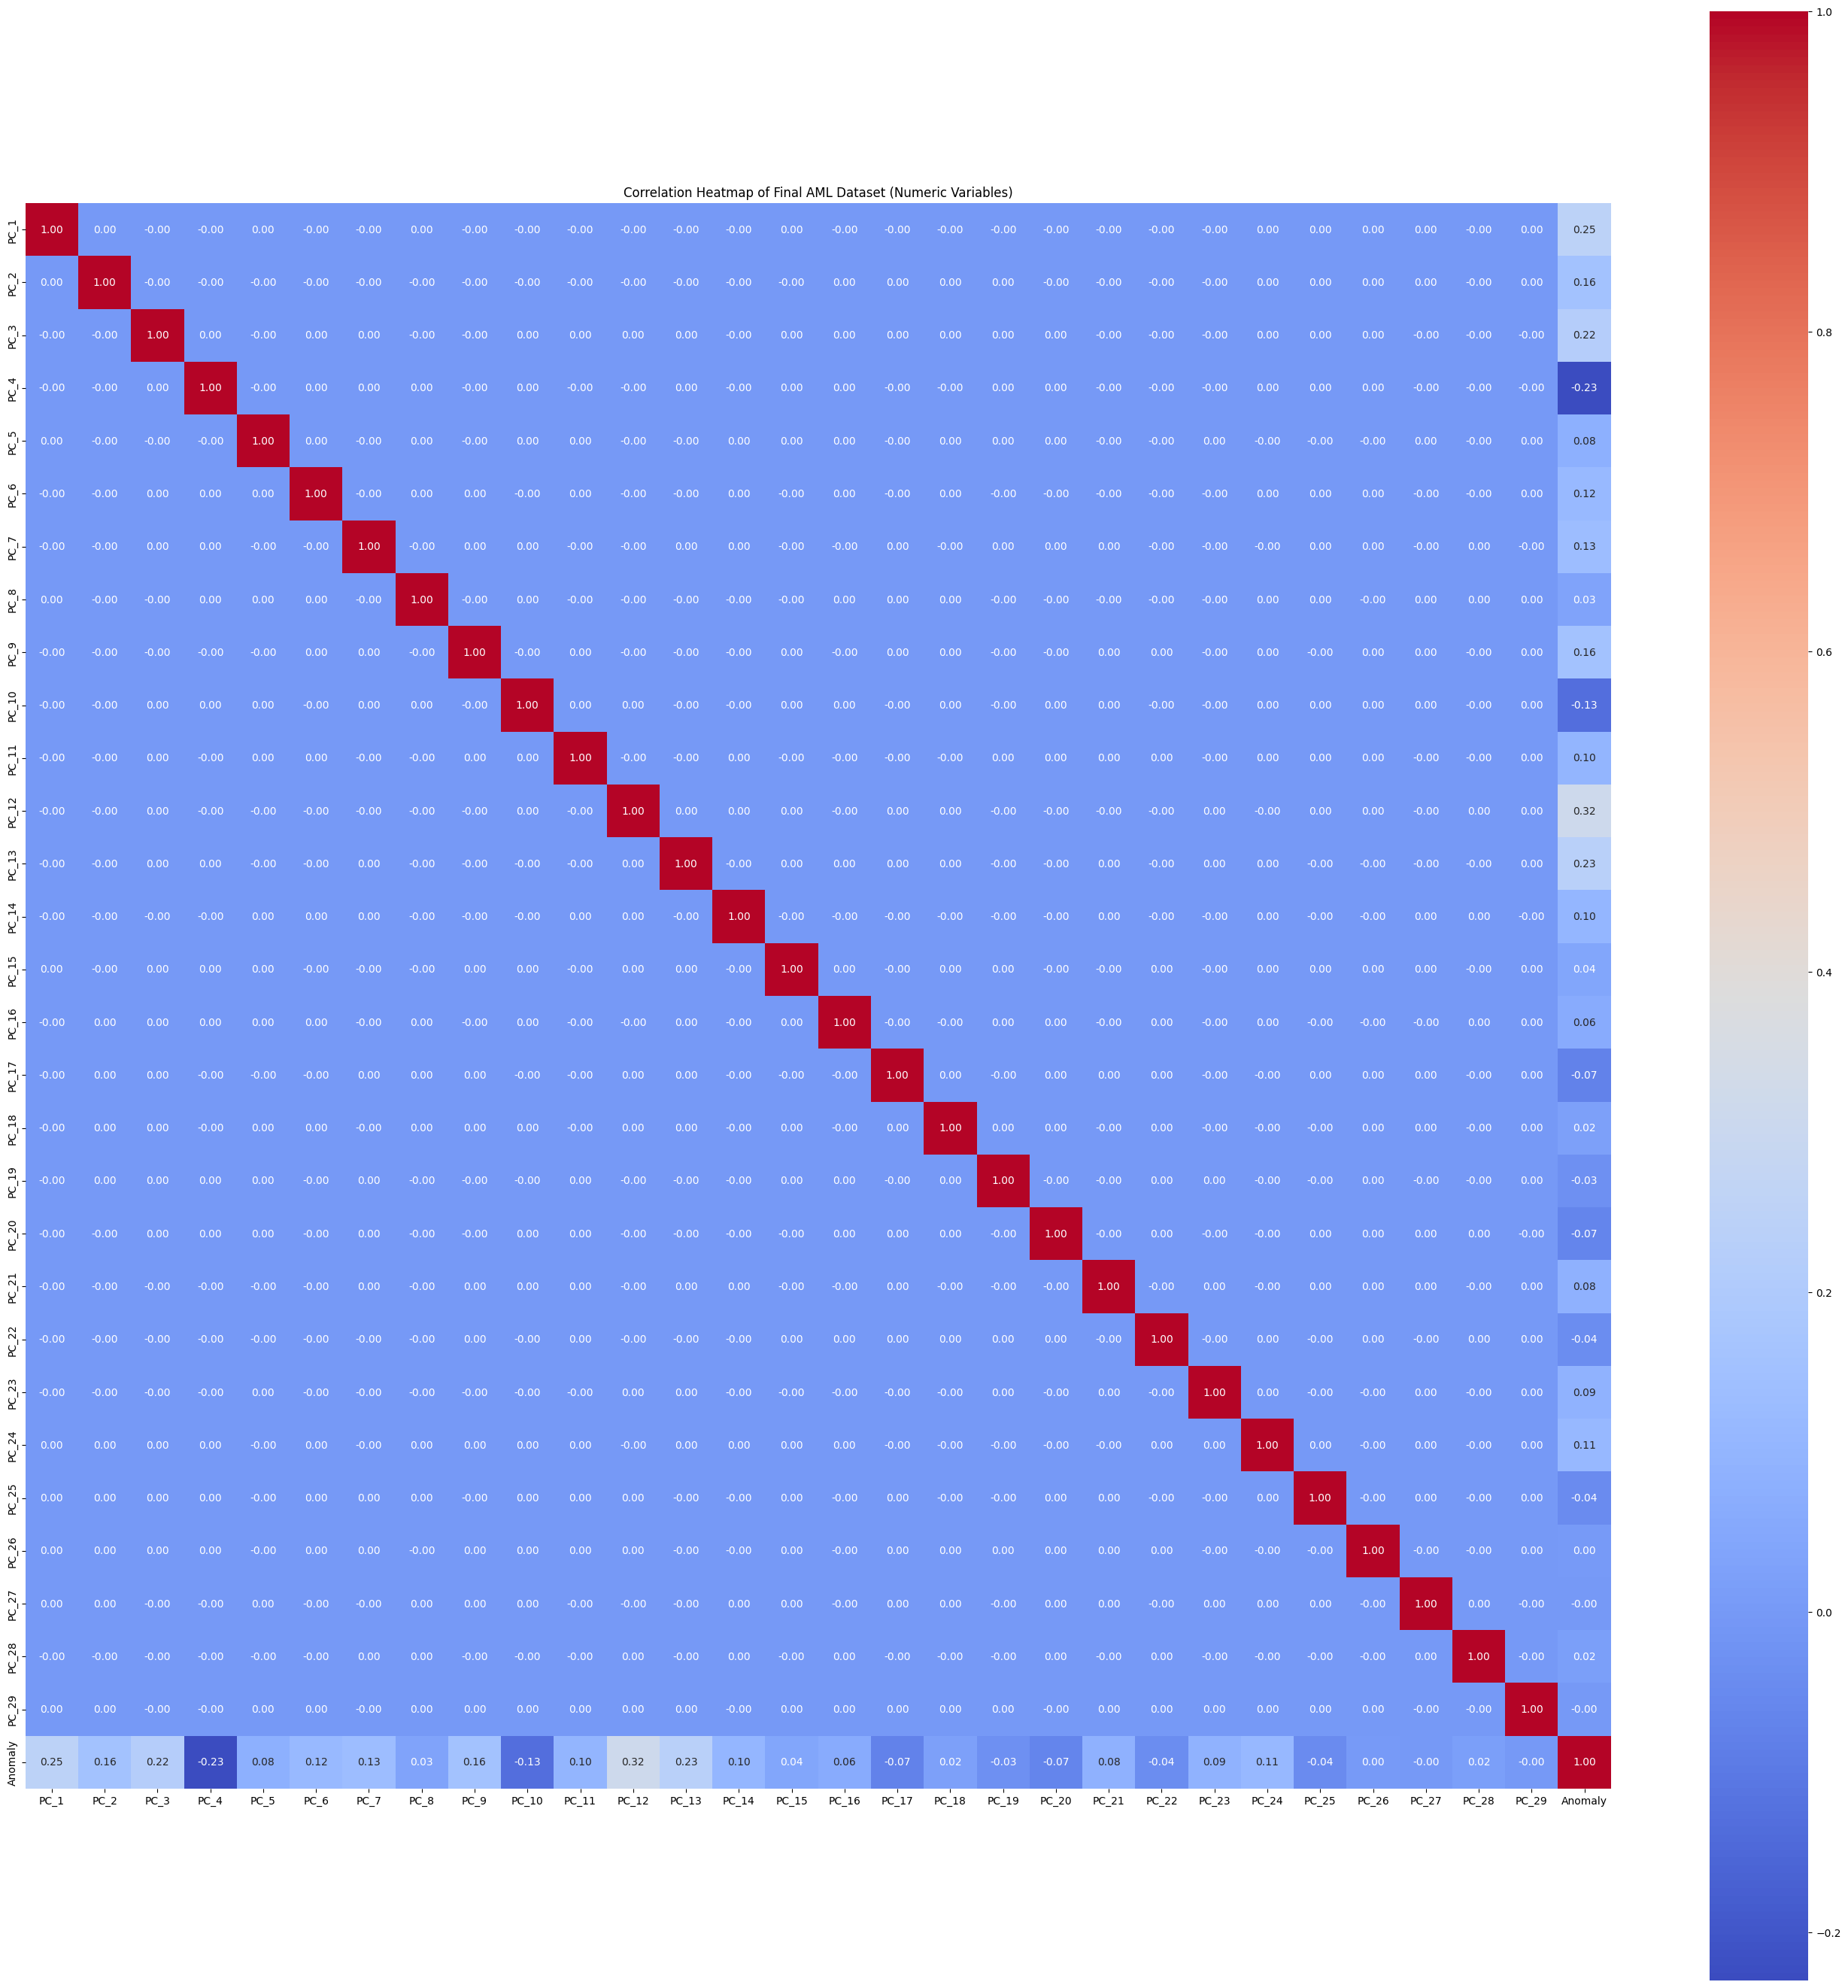

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the final AML dataset
file_path = "/content/final_aml_anomalies.csv"
df = pd.read_csv(file_path)

# Select numeric columns (these include variables such as total_transactions, median_transaction_size,
# high_value_txn_count, transaction_variance, total_amount_received, high_value_ratio, log_total_amount_cad,
# log_avg_transaction_size, activity_duration_days, transactions_per_day, inter_txn_mean_days,
# inter_txn_std_days, employee_count, sales, amount_per_employee, large_industry, medium_industry, small_industry)
numeric_cols = df.select_dtypes(include=[np.number]).columns
# Compute the correlation matrix for these numeric variables
corr_matrix = df[numeric_cols].corr()

# Set up the figure: a 31x31 inch grid to display the full heatmap
plt.figure(figsize=(34, 34))

# Create the heatmap
# - annot=True: Display correlation coefficients in each cell
# - fmt=".2f": Format the annotations to 2 decimal places
# - cmap="coolwarm": Use a diverging colormap for positive/negative correlations
# - square=True: Make each cell square-shaped
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)

# Add a title
plt.title("Correlation Heatmap of Final AML Dataset (Numeric Variables)")

# Display the plot
plt.show()
